#    BUSN 42118 01,81 Course Project
###  Business Applications of Natural Language Processing
###  Submitted by Ramkumar Shanker

References: 



Installations: 
`pip install nltk`  | 
`pip install stanfordcorenlp` |
`pip install anytree` |
`pip install graphviz` |
`pip install plotly` |

#### Importing pandas for data import, NLTK for tokenizing data, STANFORECORENLP for dependency parsing, <....>

In [1]:
import pandas as pd
import nltk
import re
import logging
import stanfordcorenlp
import networkx as nx
import matplotlib.pyplot as plt
import pandas
import math
import numpy as np
import warnings

warnings.filterwarnings('ignore')

#### Although there are available sources that already provide parsed claims, in this project we will start from raw claims text (all numbered claims in 1 box, and the go on with tokenizing them)

##### For first_cut, we'll use 10 patents belonging to the G06N CPC Classification

#### Note: the unformatted raw claims text in column 7

In [2]:
first_cut = pd.read_excel('Patent_Firstdraft_2.xlsx')
print(first_cut)

  Section Id Subsection Id Group Id Subgroup Id  Patent Id  \
0          G           G06     G06N    G06N3/00    6529276   
1          G           G06     G06N    G06N3/00    6675145   
2          G           G06     G06N    G06N3/00    7272511   
3          G           G06     G06N    G06N3/00    7447669   
4          G           G06     G06N    G06N3/00    7536364   
5          G           G06     G06N    G06N3/00    7672920   
6          G           G06     G06N    G06N3/00    8204927   
7          G           G06     G06N    G06N3/00    8712939   
8          G           G06     G06N    G06N3/00    8762305   
9          G           G06     G06N    G06N3/00    8838490   

                                               Title  \
0                       OPTICAL COMPUTATIONAL SYSTEM   
1  Method and system for integrated audiovisual s...   
2  MOLECULAR MEMORY OBTAINED USINGDNASTRAND MOLEC...   
3  Method and system for timetabling using pherom...   
4  Method and system for performing m

#### For the first cut, we will be using just one of the patents (on a higher level note - a brief exploration through the data will provide information of the overall structure of the claims)

In [3]:
claims = first_cut[first_cut.columns[6]]
print(claims[0])

1. A neural network system, said system comprising:an array of processing elements, wherein each said element performs a respective predetermined operation on one or more input signals and outputs a resulting signal to one or more other said elements or to an output device; andan optical filterthat weights the intensity of a light signal from an illuminated sample by wavelength according to a regression vector, wherein said regression vector corresponds to the combination of a plurality of weighted orthogonal components of said light signal, wherein each said orthogonal component is weighted according to the amount of data it carries related to the presence of a predetermined physical characteristic in said sample and wherein said orthogonal components comprise a compression of data carried by said light signal, andthat outputs a signal corresponding to said weighted light signal to a said element.2. The system as in claim 1, including a plurality of said optical filters.3. The system 

#### Patents follow an inherent structure in they way they are structure. 
######                - The fact that patent claims are always numbered can be used to tokenize claim text into separate claims
######                - Dependent claims usually refer to previous independent claims using certain terminologies (“ as in claim #")
######                - In the next step, we will create a custom "Claim Tokenizer" using a basic regular expression that captures the numbered nature of claims

#### For this claim, we will be using the Regular expression that captures any number (digit) followed by a full-stop

##### Reference: https://www.nltk.org/_modules/nltk/tokenize/regexp.html

In [4]:
# Use the NLTK package and insert custom regex to tokenize
from nltk.tokenize import RegexpTokenizer
s = claims[0]
tokenizer = RegexpTokenizer('[0-9]\.', gaps=True)
patent1_tokenized_into_claims = tokenizer.tokenize(s)

# Convert list of claims into a dataframe
patent1_claims = pd.DataFrame({'Claims':patent1_tokenized_into_claims})
patent1_claims['Claim_ID'] = patent1_claims.index + 1
print(patent1_claims)

                                              Claims  Claim_ID
0   A neural network system, said system comprisi...         1
1   The system as in claim 1, including a plurali...         2
2   The system as in claim 1, including a collima...         3
3   The system as in claim 3, including a bandpas...         4
4   A neural network system, said system comprisi...         5


#### In the next step, we will separately identify dependent claims from their independent claims

#### For this, we will be using the Regular expression that captures any occurrence of the word "claim" followed by a whitespace followed by a number.

#### Note: In certain patents, the claims numbers are merely digits while in other patents the dependent claims refer back to the independent claims using some form of brackets, and refer back to multiple claims For example, "as in claim (1)", "as in claims 1-4"

#### For the first cut however, we'll proceed with just the "claim 1" format

In [5]:
# Using the regex to get claim number
patent1_claims['Parent_claim_desc'] = patent1_claims['Claims'].str.extract('(claim \d\d*)', expand=True)

# Getting the numerical value of the claim number
patent1_claims['Parent_claim_num'] = patent1_claims['Parent_claim_desc'].str.extract('(\d\d*)', expand=True)

# Defining Claim node 
patent1_claims['Claim_node'] = patent1_claims['Claim_ID']

# Defining Parent node (If independent claim, Parent node = claim node)
patent1_claims['Parent_claim_num']=patent1_claims['Parent_claim_num'].fillna(0)

# Converted string mined using regex to a numerical value
for i in range(len(patent1_claims['Parent_claim_num'])):
    patent1_claims['Parent_claim_num'][i] = int(patent1_claims['Parent_claim_num'][i])
patent1_claims.loc[ patent1_claims.Parent_claim_num == 0, 'Parent_node' ] = patent1_claims.Claim_node
patent1_claims.loc[ patent1_claims.Parent_claim_num != 0, 'Parent_node' ] = patent1_claims.Parent_claim_num

print(patent1_claims) 

                                              Claims  Claim_ID  \
0   A neural network system, said system comprisi...         1   
1   The system as in claim 1, including a plurali...         2   
2   The system as in claim 1, including a collima...         3   
3   The system as in claim 3, including a bandpas...         4   
4   A neural network system, said system comprisi...         5   

  Parent_claim_desc Parent_claim_num  Claim_node Parent_node  
0               NaN                0           1           1  
1           claim 1                1           2           1  
2           claim 1                1           3           1  
3           claim 3                3           4           3  
4               NaN                0           5           5  


##### In this step, we can create the patent claims structure tree based on Claim node and Parent node

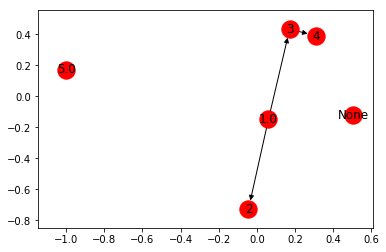

In [ ]:
#Build the graph
G=nx.DiGraph()   
G.add_nodes_from(patent1_claims.Parent_node)
G.nodes()
G.add_node('None')

#Add edges
subset = patent1_claims[['Parent_node','Claim_node']]
tuples = [tuple(x) for x in subset.values] 
G.add_edges_from(tuples)
G.number_of_edges()

#Perform Graph Drawing
#A star network  (sort of)
nx.draw_networkx(G)
plt.show()
t = input()
#A tree network (sort of)
nx.draw_graphviz(G, prog = 'dot', splines=ortho)
plt.show()

In [16]:
from stanfordcorenlp import StanfordCoreNLP

nlp = StanfordCoreNLP(r'C:\Users\sharm\OneDrive\Pictures\Rams_folder\Professional\uchicago\nlp\Final_Project\stanford-corenlp-full-2018-02-27')

sentence = patent1_claims.iloc[1, 0]
print ('Part of Speech:', nlp.pos_tag(sentence))
print ('Constituency Parsing:', nlp.parse(sentence))
print ('Dependency Parsing:', nlp.dependency_parse(sentence))

nlp.close() 

INFO:root:Initializing native server...
INFO:root:java -Xmx4g -cp "C:\Users\sharm\OneDrive\Pictures\Rams_folder\Professional\uchicago\nlp\Final_Project\stanford-corenlp-full-2018-02-27\*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9002
INFO:root:Server shell PID: 8216
INFO:root:The server is available.
INFO:root:{'properties': "{'annotators': 'pos', 'outputFormat': 'json'}", 'pipelineLanguage': 'en'}
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): localhost
DEBUG:urllib3.connectionpool:http://localhost:9002 "POST /?properties=%7B%27annotators%27%3A+%27pos%27%2C+%27outputFormat%27%3A+%27json%27%7D&pipelineLanguage=en HTTP/1.1" 200 2046
INFO:root:{'properties': "{'annotators': 'pos,parse', 'outputFormat': 'json'}", 'pipelineLanguage': 'en'}
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): localhost


Part of Speech: [('The', 'DT'), ('system', 'NN'), ('as', 'IN'), ('in', 'IN'), ('claim', 'NN'), ('1', 'CD'), (',', ','), ('including', 'VBG'), ('a', 'DT'), ('plurality', 'NN'), ('of', 'IN'), ('said', 'VBD'), ('optical', 'JJ'), ('filters', 'NNS'), ('.', '.')]


DEBUG:urllib3.connectionpool:http://localhost:9002 "POST /?properties=%7B%27annotators%27%3A+%27pos%2Cparse%27%2C+%27outputFormat%27%3A+%27json%27%7D&pipelineLanguage=en HTTP/1.1" 200 6692
INFO:root:{'properties': "{'annotators': 'depparse', 'outputFormat': 'json'}", 'pipelineLanguage': 'en'}
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): localhost


Constituency Parsing: (ROOT
  (S
    (NP
      (NP (DT The) (NN system))
      (PP (IN as)
        (PP (IN in)
          (NP
            (NP (NN claim) (CD 1))
            (, ,)
            (PP (VBG including)
              (NP
                (NP (DT a) (NN plurality))
                (PP (IN of))))))))
    (VP (VBD said)
      (NP (JJ optical) (NNS filters)))
    (. .)))


DEBUG:urllib3.connectionpool:http://localhost:9002 "POST /?properties=%7B%27annotators%27%3A+%27depparse%27%2C+%27outputFormat%27%3A+%27json%27%7D&pipelineLanguage=en HTTP/1.1" 200 6307
INFO:root:Cleanup...
INFO:root:Killing pid: 13784, cmdline: ['java', '-Xmx4g', '-cp', 'C:\\Users\\sharm\\OneDrive\\Pictures\\Rams_folder\\Professional\\uchicago\\nlp\\Final_Project\\stanford-corenlp-full-2018-02-27\\*', 'edu.stanford.nlp.pipeline.StanfordCoreNLPServer', '-port', '9002']
INFO:root:Killing shell pid: 8216, cmdline: ['C:\\WINDOWS\\system32\\cmd.exe', '/c', 'java -Xmx4g -cp C:\\Users\\sharm\\OneDrive\\Pictures\\Rams_folder\\Professional\\uchicago\\nlp\\Final_Project\\stanford-corenlp-full-2018-02-27\\* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9002']


Dependency Parsing: [('ROOT', 0, 2), ('det', 2, 1), ('case', 5, 3), ('case', 5, 4), ('nmod', 2, 5), ('nummod', 5, 6), ('punct', 5, 7), ('case', 10, 8), ('det', 10, 9), ('nmod', 5, 10), ('case', 14, 11), ('dep', 14, 12), ('amod', 14, 13), ('nmod', 10, 14), ('punct', 2, 15)]
